In [1]:
%matplotlib inline
import seaborn
import numpy as np, scipy, IPython.display as ipd, matplotlib.pyplot as plt
import librosa, librosa.display
plt.rcParams['figure.figsize'] = (14, 5)

In [4]:
filename = '../data/grandpiano.wav'
x, sr = librosa.load(filename,duration=10)

In [5]:
ipd.Audio(x,rate=sr)

CQT of the signal:  
similar to fourier transform but uses logarithmically spaced frequency axis.



In [6]:
bins_per_octave = 36

cqt = librosa.cqt(x, sr=sr, n_bins=300, bins_per_octave = bins_per_octave)
log_cqt = librosa.amplitude_to_db(np.abs(cqt))

In [7]:
cqt.shape


(300, 431)

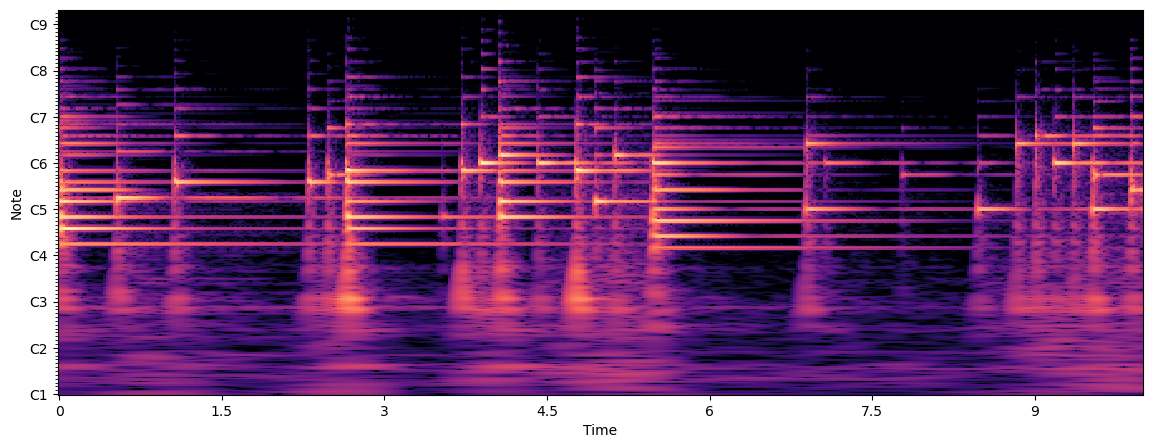

In [8]:
librosa.display.specshow(log_cqt, sr=sr, x_axis='time', y_axis='cqt_note',bins_per_octave = bins_per_octave)

STEP 1: Detect onsets

In [9]:
hop_length = 100
onset_env = librosa.onset.onset_strength(x, sr=sr, hop_length=hop_length)

/var/folders/pt/c3pppqgj6rx6ydqlk9zj4s1w0000gn/T/ipykernel_11641/856406037.py:2: FutureWarning: Pass y=[5.8856867e-06 4.8249698e-05 4.7293855e-05 ... 1.1374019e-02 8.9986315e-03
 7.0110448e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_env = librosa.onset.onset_strength(x, sr=sr, hop_length=hop_length)


(0.0, 2206.0)

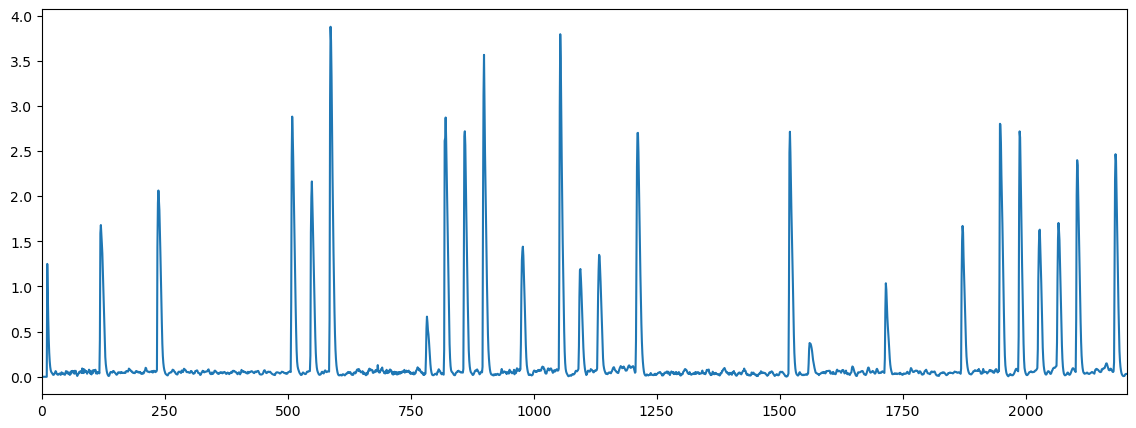

In [10]:
plt.plot(onset_env)
plt.xlim(0, len(onset_env))

In [11]:
onset_samples = librosa.onset.onset_detect(x, sr=sr, units='samples',
hop_length=hop_length, backtrack=False, pre_max=20, post_max=20, 
pre_avg=100, post_avg=100, delta=0.2, wait=0)

/var/folders/pt/c3pppqgj6rx6ydqlk9zj4s1w0000gn/T/ipykernel_11641/2947029760.py:1: FutureWarning: Pass y=[5.8856867e-06 4.8249698e-05 4.7293855e-05 ... 1.1374019e-02 8.9986315e-03
 7.0110448e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_samples = librosa.onset.onset_detect(x, sr=sr, units='samples',


In [12]:
onset_samples

array([  1100,  12000,  23700,  50900,  54900,  58700,  82100,  86000,
        89900,  97800, 105400, 109500, 113300, 121200, 152100, 171600,
       187200, 194800, 198800, 202900, 206700, 210500, 218300])

In [13]:
onset_boundaries = np.concatenate([[0], onset_samples, [len(x)]])

In [14]:
print(onset_boundaries)

[     0   1100  12000  23700  50900  54900  58700  82100  86000  89900
  97800 105400 109500 113300 121200 152100 171600 187200 194800 198800
 202900 206700 210500 218300 220500]


In [15]:
onset_times = librosa.samples_to_time(onset_boundaries, sr=sr)
onset_times

array([ 0.        ,  0.04988662,  0.54421769,  1.07482993,  2.30839002,
        2.48979592,  2.66213152,  3.72335601,  3.90022676,  4.07709751,
        4.43537415,  4.78004535,  4.96598639,  5.138322  ,  5.49659864,
        6.89795918,  7.78231293,  8.48979592,  8.83446712,  9.01587302,
        9.20181406,  9.37414966,  9.54648526,  9.90022676, 10.        ])

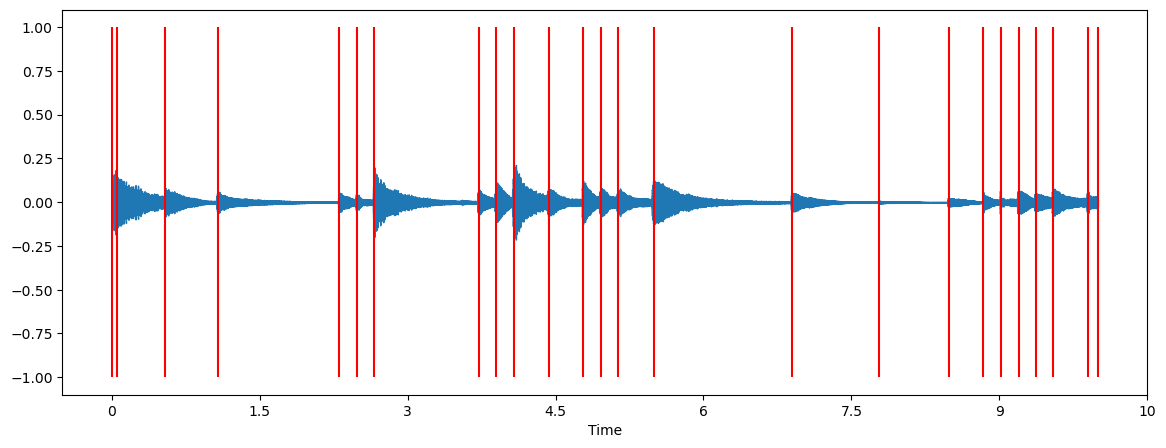

In [16]:
librosa.display.waveshow(x, sr=sr)
plt.vlines(onset_times, -1, 1, color='r')

In [17]:
def estimate_pitch(segment, sr, fmin=50.0, fmax=2000.0):
    
    # Compute autocorrelation of input segment.
    r = librosa.autocorrelate(segment)
    
    # Define lower and upper limits for the autocorrelation argmax.
    i_min = sr/fmax
    i_max = sr/fmin
    r[:int(i_min)] = 0
    r[int(i_max):] = 0
    
    # Find the location of the maximum autocorrelation.
    i = r.argmax()
    f0 = float(sr)/i
    return f0

In [18]:
def generate_sine(f0, sr, n_duration):
    n = np.arange(n_duration)
    return 0.2*np.sin(2*np.pi*f0*n/float(sr))

In [19]:
def estimate_pitch_and_generate_sine(x, onset_samples, i, sr):
    n0 = onset_samples[i]
    n1 = onset_samples[i+1]
    f0 = estimate_pitch(x[n0:n1], sr)
    return generate_sine(f0, sr, n1-n0)

In [20]:
y = np.concatenate([
    estimate_pitch_and_generate_sine(x, onset_boundaries, i, sr=sr)
    for i in range(len(onset_boundaries)-1)
])

In [21]:
ipd.Audio(y, rate=sr)

In [22]:
cqt = librosa.cqt(y, sr=sr)


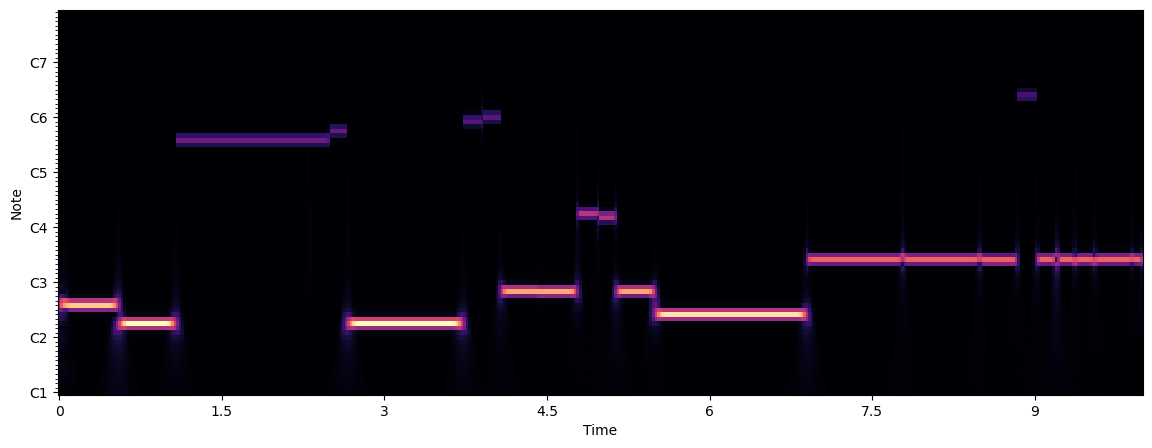

In [23]:
librosa.display.specshow(abs(cqt), sr=sr, x_axis='time', y_axis='cqt_note')